# 펀드 위험등급 산출

## 패키지 로드

In [1]:
%matplotlib inline

In [2]:
import functools
import os
import re
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange

In [3]:
plt.rc('font', family='Malgun Gothic')  # For Windows

## 변수 정의

In [4]:
TEST_PROCESS = eval(os.environ.get('TEST_PROCESS', 'True'))
VALIDATE_PROCESS = eval(os.environ.get('VALIDATE_PROCESS', 'True'))
DATA_FILEPATH = os.environ.get('DATA_FILEPATH', './data/TYPE_10_채권형.csv')
BINS = eval(os.environ.get('BINS', '[0, 0.005, 0.05, 0.10, 0.15, 0.25, float("inf")]'))

if isinstance(BINS, list):
    DICT_BINS = defaultdict(lambda: BINS)
elif isinstance(BINS, dict):
    assert all(idx_col in BINS for idx_col in ['std_1y', 'std_3y', 'var_3y'])
    DICT_BINS = BINS

print(f'{TEST_PROCESS=}, {VALIDATE_PROCESS=}, {DATA_FILEPATH=}, {BINS=}, {DICT_BINS=}')

TEST_PROCESS=False, VALIDATE_PROCESS=False, DATA_FILEPATH='data\\TYPE_24_부동산형.csv', BINS={'std_1y': [0, 0.005, 0.05, 0.1, 0.15, 0.25, inf], 'std_3y': [0, 0.005, 0.05, 0.1, 0.15, 0.25, inf], 'var_3y': [0, 0.005, 0.05, 0.1, 0.2, 0.3, inf]}, DICT_BINS={'std_1y': [0, 0.005, 0.05, 0.1, 0.15, 0.25, inf], 'std_3y': [0, 0.005, 0.05, 0.1, 0.15, 0.25, inf], 'var_3y': [0, 0.005, 0.05, 0.1, 0.2, 0.3, inf]}


## 타입 추출

In [5]:
filepath = Path(DATA_FILEPATH)
filename_pattern = re.compile(r'TYPE_([0-9]+)_([^_]+)\.csv')

match_rst = re.fullmatch(filename_pattern, filepath.name)
type_no, type_name = match_rst.groups()

type_no, type_name

('24', '부동산형')

## 데이터 로드

In [6]:
lists_wo_idx_df = pd.read_csv(filepath, names=["date", "code", "nav"], usecols=[0, 1, 2], parse_dates=[0])
lists_df = lists_wo_idx_df.set_index(['code', 'date'])

codes = lists_df.index.get_level_values('code').unique()
print(f"{len(codes)=}")

len(codes)=58


## 수치 산출 테스트

1년을 기준으로 프로세스 정의

### 기간 조건 적용

In [7]:
if TEST_PROCESS:
    lists_1y_df = pd.concat([
        lists_df.xs(code).last('1y').assign(code=code)
        for code in codes])
    lists_1y_df.reset_index(inplace=True)
    display(lists_1y_df)

### 리샘플링, 퍼센트 체인지 추출

In [8]:
if TEST_PROCESS:
    lists_1y_wk_df = lists_1y_df.set_index(['date']).groupby(['code'])[['nav']].resample('W').last()
    lists_1y_wk_df = lists_1y_wk_df.assign(ret=lists_1y_wk_df.groupby(['code'])[['nav']].pct_change())
    display(lists_1y_wk_df)

### 표준편차 산출

In [9]:
if TEST_PROCESS:
    lists_1y_std_df = lists_1y_wk_df.groupby(['code'])[['ret']].std(numeric_only=True) * np.sqrt(52)
    lists_1y_std_df.reset_index(inplace=True)
    lists_1y_std_df.rename(columns={'ret': 'std_1y'}, inplace=True)
    display(lists_1y_std_df)

### VaR 산출

In [10]:
if TEST_PROCESS:
    lists_1y_var_df = lists_1y_wk_df.groupby(['code'])[['ret']].quantile(0.025, numeric_only=True)
    lists_1y_var_df = np.minimum(lists_1y_var_df, 0) * -1 * np.sqrt(52)
    lists_1y_var_df.rename(columns={'ret': 'var_1y'}, inplace=True)
    display(lists_1y_var_df)

## 수치 산출 프로세스 정의

In [11]:
offsets = ['1y', '3y']

In [12]:
%%time

lists_rst_dfs = []

for offset in offsets:
    lists_off_df = pd.concat([
        lists_df.xs(code).last(offset).assign(code=code)
        for code in codes])
    lists_off_df.reset_index(inplace=True)

    lists_off_wk_df = lists_off_df.set_index(['date']).groupby(['code'])[['nav']].resample('W').last()
    lists_off_wk_df = lists_off_wk_df.assign(ret=lists_off_wk_df.groupby(['code'])[['nav']].pct_change())

    lists_off_std_df = lists_off_wk_df.groupby(['code'])[['ret']].std(numeric_only=True) * np.sqrt(52)
    lists_off_std_df.rename(columns={'ret': f'std_{offset}'}, inplace=True)

    lists_off_var_df = lists_off_wk_df.groupby(['code'])[['ret']].quantile(0.025, numeric_only=True)
    lists_off_var_df = np.minimum(lists_off_var_df, 0) * -1 * np.sqrt(52)
    lists_off_var_df.rename(columns={'ret': f'var_{offset}'}, inplace=True)

    lists_rst_dfs.append(lists_off_std_df)
    lists_rst_dfs.append(lists_off_var_df)

lists_rst_df = pd.concat(lists_rst_dfs, axis='columns')
lists_rst_df

CPU times: total: 656 ms
Wall time: 671 ms


,std_1y,var_1y,std_3y,var_3y
code,,,,
K55203CE0163,0.451748,1.713308,0.422670,1.588136
K55210BM8648,0.104962,0.129920,0.063965,0.012305
K55210BM8655,0.039856,0.130372,0.035712,0.160606
K55210BM8663,0.039856,0.130372,0.035712,0.160606
K55223CJ6351,0.023304,0.084170,0.023304,0.084170
K55223CJ6369,0.023308,0.085324,0.023308,0.085324
K55223CJ6377,0.023294,0.085929,0.023294,0.085929
K55223CJ6385,0.023309,0.084812,0.023309,0.084812
K55223CS0338,0.010114,0.029419,0.010114,0.029419


### 프로세스 테스트

In [13]:
%%time

def calc_std_y(code):
    df = lists_wo_idx_df[lists_wo_idx_df['code'] == code][["date", "nav"]]
    df = df.sort_values(by="date")
    df = df.set_index("date")

    df_1y = df.last("1Y")
    df_1y_w = df_1y.resample("W").last()

    df_3y = df.last("3Y")
    df_3y_w = df_3y.resample("W").last()

    df_3y_w["ret"] = df_3y_w["nav"].pct_change()
    df_3y_w = df_3y_w.iloc[1:]
    std_3y = df_3y_w["ret"].std() * np.sqrt(52)

    df_1y_w["ret"] = df_1y_w["nav"].pct_change()
    df_1y_w = df_1y_w.iloc[1:]
    std_1y = df_1y_w["ret"].std() * np.sqrt(52)

    var_3y = -np.minimum(df_3y_w["ret"].quantile(0.025), 0) * np.sqrt(52)

    return std_3y, std_1y, var_3y

if VALIDATE_PROCESS:
    list_std_y = []
    for i in trange(len(codes)):
        code = codes[i]
        list_std_y.append(calc_std_y(code))

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
if VALIDATE_PROCESS:
    for code_idx, code in enumerate(codes):
        for old_idx, new_name in [(0, 'std_3y'), (1, 'std_1y'), (2, 'var_3y')]:
            old_rst = list_std_y[code_idx][old_idx]
            new_rst = lists_rst_df.xs(code).xs(new_name)
            if not np.isclose(old_rst, new_rst, equal_nan=True):
                print(f"{code=}, {old_rst=}, {new_rst=}, {np.isclose(old_rst, new_rst, equal_nan=True)=}")

## 등급 변환

In [15]:
labels = ["6등급", "5등급", "4등급", "3등급", "2등급", "1등급"]
cut_fn = functools.partial(pd.cut, labels=labels)

lists_lb_df = lists_rst_df.assign(
    risk_std_1y=cut_fn(lists_rst_df['std_1y'], bins=DICT_BINS['std_1y']),
    risk_std_3y=cut_fn(lists_rst_df['std_3y'], bins=DICT_BINS['std_3y']),
    # risk_var_1y=cut_fn(lists_rst_df['var_1y']),
    risk_var_3y=cut_fn(lists_rst_df['var_3y'], bins=DICT_BINS['var_3y']))
lists_lb_df.dropna(inplace=True)
lists_lb_df.reset_index(inplace=True)

lists_lb_df

,code,std_1y,var_1y,std_3y,var_3y,risk_std_1y,risk_std_3y,risk_var_3y
0,K55203CE0163,0.451748,1.713308,0.422670,1.588136,1등급,1등급,1등급
1,K55210BM8648,0.104962,0.129920,0.063965,0.012305,3등급,4등급,5등급
2,K55210BM8655,0.039856,0.130372,0.035712,0.160606,5등급,5등급,3등급
3,K55210BM8663,0.039856,0.130372,0.035712,0.160606,5등급,5등급,3등급
4,K55223CJ6351,0.023304,0.084170,0.023304,0.084170,5등급,5등급,4등급
5,K55223CJ6369,0.023308,0.085324,0.023308,0.085324,5등급,5등급,4등급
6,K55223CJ6377,0.023294,0.085929,0.023294,0.085929,5등급,5등급,4등급
7,K55223CJ6385,0.023309,0.084812,0.023309,0.084812,5등급,5등급,4등급
8,K55223CS0338,0.010114,0.029419,0.010114,0.029419,5등급,5등급,5등급
9,K55223CS0353,0.010101,0.029441,0.010101,0.029441,5등급,5등급,5등급


#### 프로세스 테스트

In [16]:
if VALIDATE_PROCESS:
    list_std_3y, list_std_1y, list_var_3y = zip(*list_std_y)

    df_result = pd.DataFrame({
        "code": codes,
        "std_3y": list_std_3y,
        "std_1y": list_std_1y,
        "var_3y": list_var_3y,
    })

    bins = [0, 0.005, 0.05, 0.10, 0.15, 0.25, float("inf")]
    labels = ["6등급", "5등급", "4등급", "3등급", "2등급", "1등급"]

    df_result["risk_std_3y"] = pd.cut(df_result.std_3y, bins=bins, labels=labels)
    df_result["risk_std_1y"] = pd.cut(df_result.std_1y, bins=bins, labels=labels)
    df_result["risk_var_3y"] = pd.cut(df_result.var_3y, bins=bins, labels=labels)

    df_result = df_result.dropna()

In [17]:
if VALIDATE_PROCESS:
    display(
        (lists_lb_df[['code', 'risk_std_1y', 'risk_std_3y', 'risk_var_3y']].set_index(['code'])
        == df_result[['code', 'risk_std_1y', 'risk_std_3y', 'risk_var_3y']].set_index(['code'])).all())

## 등급 결과 출력

In [18]:
os.makedirs('result', exist_ok=True)
lists_lb_df.to_csv(f'result/RESULT_{type_no}_{type_name}.csv', index=False)

## 시각화

In [19]:
risk_std_3y_stat_df = lists_lb_df["risk_std_3y"].value_counts().sort_index(ascending=False)
risk_std_1y_stat_df = lists_lb_df["risk_std_1y"].value_counts().sort_index(ascending=False)
risk_var_3y_stat_df = lists_lb_df["risk_var_3y"].value_counts().sort_index(ascending=False)
stat_df = pd.concat([risk_std_3y_stat_df, risk_std_1y_stat_df, risk_var_3y_stat_df], axis=1)
stat_df = stat_df.rename(columns={"risk_std_3y": "3년 표준편차", "risk_std_1y": "1년 표준편차", "risk_var_3y": "3년 VaR"})
stat_df.reset_index(names=['등급'], inplace=True)

stat_df.set_index('등급').style.background_gradient()

,3년 표준편차,1년 표준편차,3년 VaR
등급,,,
1등급,9,10,9
2등급,1,0,1
3등급,0,2,16
4등급,8,7,16
5등급,32,31,8
6등급,1,1,1


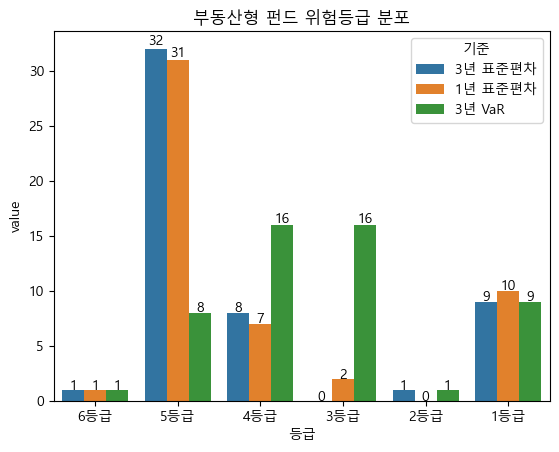

In [20]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height() * 0.01)
                value = '{:d}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() * 0.5)
                value = '{:d}'.format(int(p.get_width()))
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


stat_df_long = (
    stat_df
    .melt(id_vars="등급", value_vars=["3년 표준편차", "1년 표준편차", "3년 VaR"], var_name="기준") \
    .rename(columns={"index": "등급"})
)
axis = sns.barplot(x="등급", y="value", hue="기준", data=stat_df_long)
axis.set_title(f"{type_name} 펀드 위험등급 분포")
show_values(axis)

## 통계 결과 출력

In [21]:
os.makedirs('result', exist_ok=True)
stat_df.to_csv(f'result/STATISTICS_{type_no}_{type_name}.csv', index=False)